In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import seaborn as sns
from itertools import product

/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/seml/database.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
collection_name = 'week11_spectral_norm_cora_ml'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    with open(ex['result']) as f:
        ex['result'] = json.load(f)

print(f'Number of finished experiments : {len(experiments)}')

Number of finished experiments : 76


In [92]:
SETTING = 'Setting'
RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Normalzation'
NORMALIZE_OUTPUT = 'Spectral Output Normalization'
ACCURACY = 'Accuracy'
ECE = 'Expected Calibration Error'
WEIGHT_SCALE = 'Weight Scale'
LIPSCHITZ = 'Median Empirical Lipschitz Constant'
LIPSCHITZ_MAX = 'Max Empirical Lipschitz Constant'
OOD = 'Out of Distribution Setting'
PROXY = 'Proxy'
LOC = 'LoC'
BERNOULLI = 'Bernoulli'
NORMAL = 'Normal'
GPC = 'Feature Density GPC'
MAX_SCORE = 'Max Softmax Score'
AUROC = 'AUC-ROC'
TRANSDUCTIVE = 'Transductive'
HYBRID = 'Hybrid'

In [93]:
list(ex['result'].keys())

['val_loss-val-train-labels-0',
 'val_accuracy-val-train-labels-0',
 'val_loss-val-reduced-0',
 'val_accuracy-val-reduced-0',
 'ece_val-reduced',
 'ece_val-reduced_no_edges',
 'accuracy_val-reduced',
 'accuracy_id_val-reduced',
 'accuracy_ood_val-reduced',
 'accuracy_val-reduced_no-edges',
 'accuracy_id_val-reduced_no-edges',
 'accuracy_ood_val-reduced_no-edges',
 'accuracy_val_loc',
 'accuracy_id_val_loc',
 'accuracy_ood_val_loc',
 'accuracy_val_loc-no-edges',
 'accuracy_id_val_loc-no-edges',
 'accuracy_ood_val_loc-no-edges',
 'accuracy_val-reduced-bernoulli_bernoulli',
 'accuracy_id_val-reduced-bernoulli_bernoulli',
 'accuracy_ood_val-reduced-bernoulli_bernoulli',
 'accuracy_val-reduced-bernoulli_bernoulli-no-edges',
 'accuracy_id_val-reduced-bernoulli_bernoulli-no-edges',
 'accuracy_ood_val-reduced-bernoulli_bernoulli-no-edges',
 'accuracy_val-reduced-normal_normal',
 'accuracy_id_val-reduced-normal_normal',
 'accuracy_ood_val-reduced-normal_normal',
 'accuracy_val-reduced-normal_no

In [94]:
data = []
data_auroc = []
for ex in experiments:
    for idx in range(ex['config']['data']['num_dataset_splits'] * ex['config']['model']['num_initializations']):
        
        
        base = {
            SETTING : HYBRID if ex['config']['data']['train_labels_remove_other'] else TRANSDUCTIVE,
            RESIDUAL : ex['config']['model']['residual'],
            SPECTRAL_NORM : ex['config']['model']['use_spectral_norm'],
            WEIGHT_SCALE : (ex['config']['model']['weight_scale']),
            LIPSCHITZ : ex['result']['empirical_lipschitz_val_slope_median_perturbation_noise-perturbations'][idx],
            LIPSCHITZ_MAX : ex['result']['empirical_lipschitz_val_slope_max_perturbation_noise-perturbations'][idx],
        }
        if ex['config']['model']['use_spectral_norm'] == False:
            # Duplicate the values for no spectral norm (once with and once without output normalization)
            base[NORMALIZE_OUTPUT] = False
            base[WEIGHT_SCALE] = np.nan
        else:
            base[NORMALIZE_OUTPUT] = ex['config']['model']['use_spectral_norm_on_last_layer']

        data.append(base | {
            ACCURACY : ex['result']['accuracy_val-reduced'][idx],
            ECE : ex['result']['ece_val-reduced'][idx],
        })
        data_auroc.append(base | {
            PROXY : GPC,
            AUROC : ex['result']['auroc_gpc-full-weighted:no_loc'][idx],
            OOD : LOC,
        })
        data_auroc.append(base | {
            PROXY : GPC,
            AUROC : ex['result']['auroc_gpc-full-weighted:no_bernoulli'][idx],
            OOD : BERNOULLI,
        })
        data_auroc.append(base | {
            PROXY : GPC,
            AUROC : ex['result']['auroc_gpc-full-weighted:no_normal'][idx],
            OOD : NORMAL,
        })
        data_auroc.append(base | {
            PROXY : MAX_SCORE,
            AUROC : ex['result']['auroc_max-score_loc'][idx],
            OOD : LOC,
        })
        data_auroc.append(base | {
            PROXY : MAX_SCORE,
            AUROC : ex['result']['auroc_max-score_bernoulli'][idx],
            OOD : BERNOULLI,
        })
        data_auroc.append(base | {
            PROXY : MAX_SCORE,
            AUROC : ex['result']['auroc_max-score_normal'][idx],
            OOD : NORMAL,
        })
        
        
df = pd.DataFrame(data)
df_auroc = pd.DataFrame(data_auroc)
df_merged = pd.merge(df_auroc, df)

In [95]:
_confidence_interval = 95 # Set to a value in percent or "sd"

## Effects of Weight Scale on Accuracy, Calibration and Lipschitz Constant

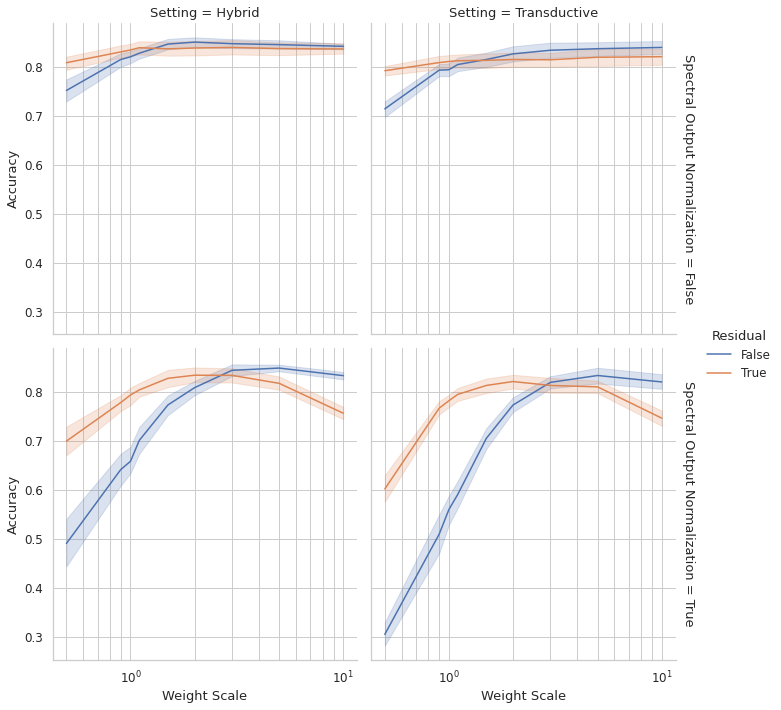

In [70]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = WEIGHT_SCALE, y = ACCURACY, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, ci=_confidence_interval)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

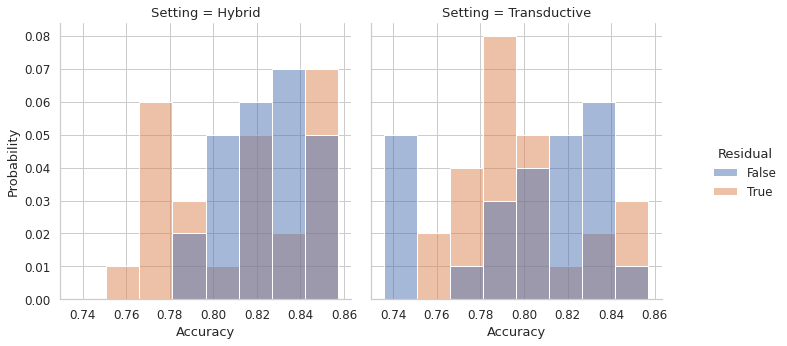

In [71]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df[df[SPECTRAL_NORM] == False], x=ACCURACY, hue = RESIDUAL, col = SETTING, 
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

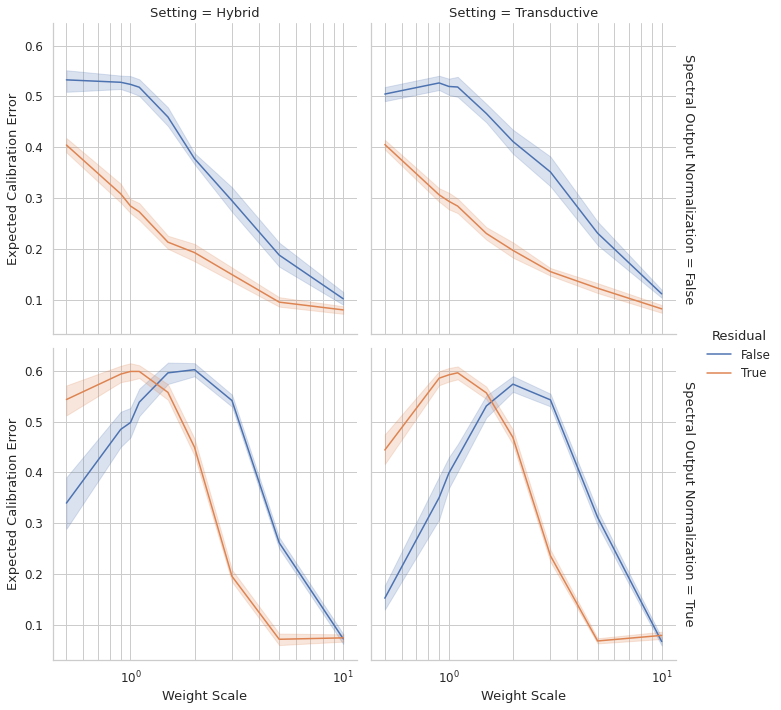

In [72]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = WEIGHT_SCALE, y = ECE, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, ci=_confidence_interval)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

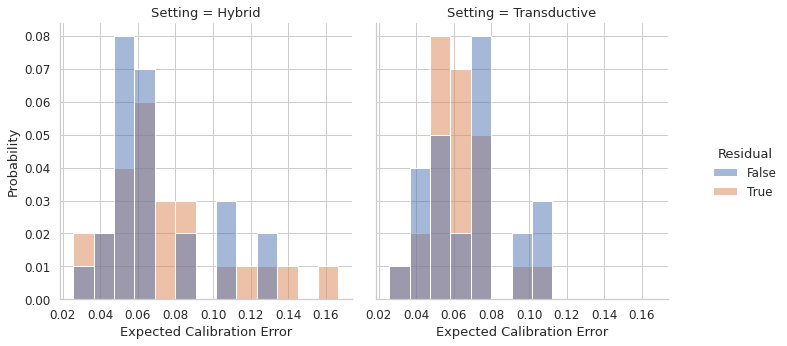

In [73]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df[df[SPECTRAL_NORM] == False], x=ECE, hue = RESIDUAL, col = SETTING, 
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

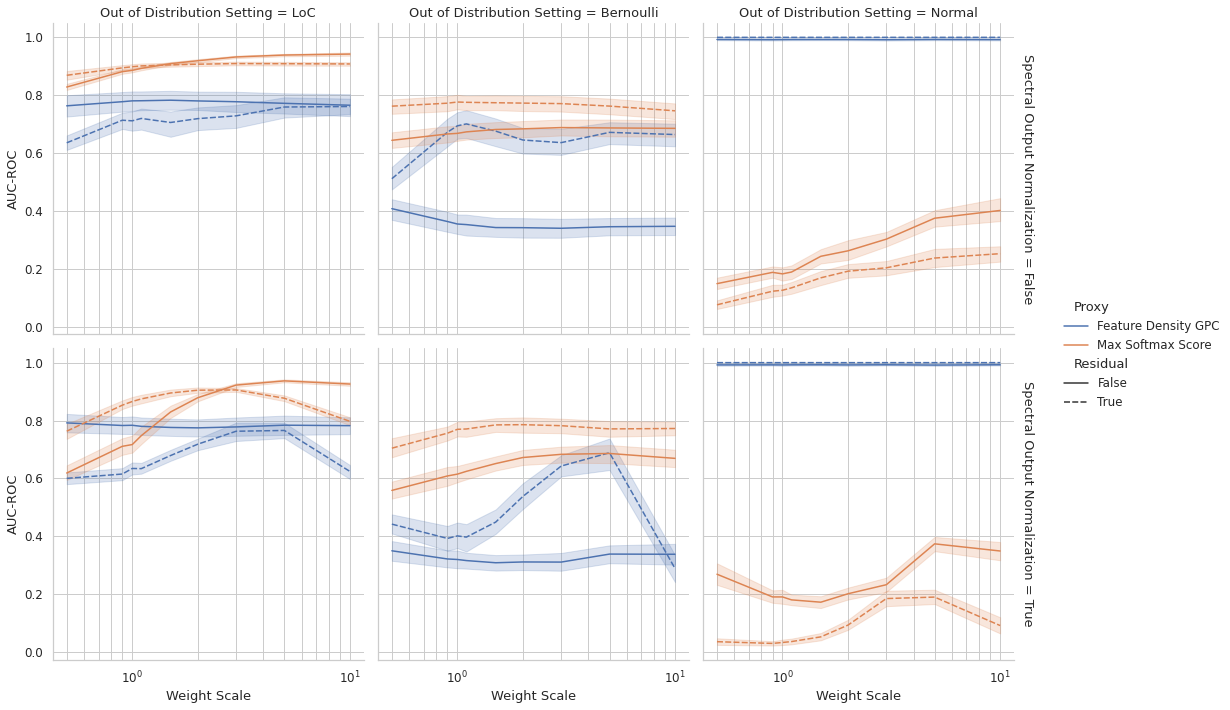

In [74]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df_auroc[df_auroc[SETTING] == HYBRID] , x = WEIGHT_SCALE, y = AUROC, hue = PROXY, col = OOD, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, style=RESIDUAL, ci=_confidence_interval)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

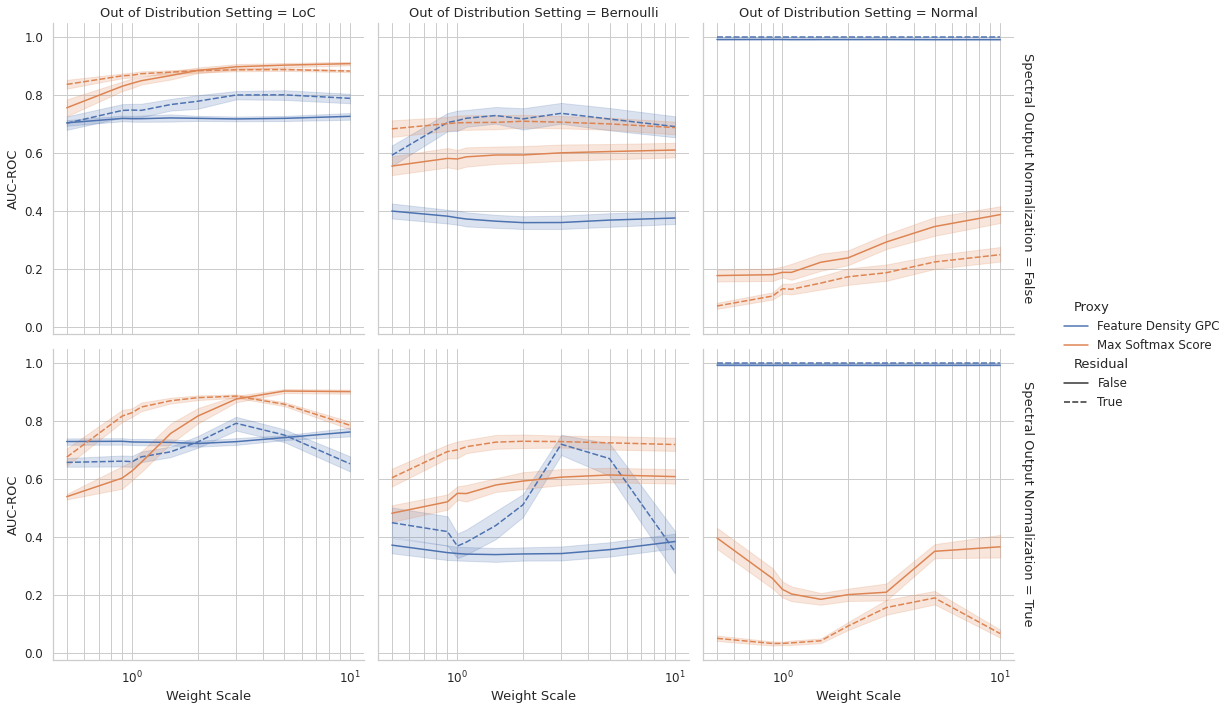

In [75]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df_auroc[df_auroc[SETTING] == TRANSDUCTIVE] , x = WEIGHT_SCALE, y = AUROC, hue = PROXY, col = OOD, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, style=RESIDUAL, ci=_confidence_interval)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

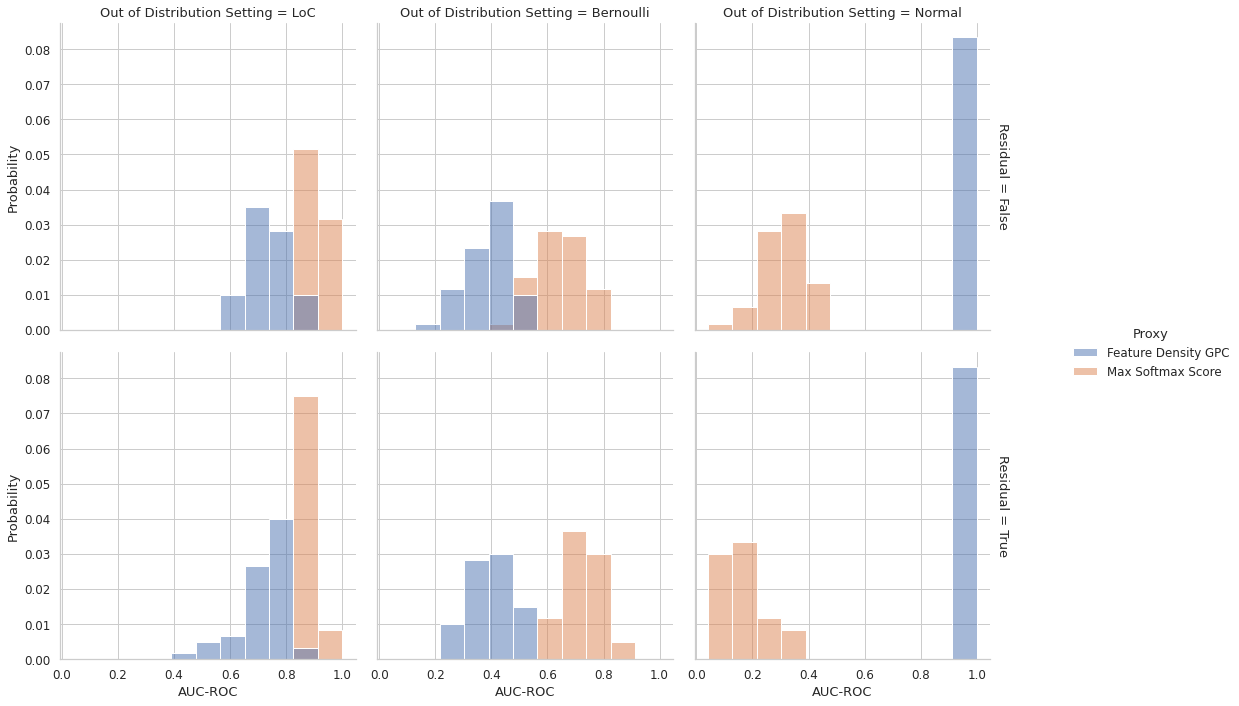

In [76]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df_auroc[df_auroc[SPECTRAL_NORM] == False], x=AUROC, hue = PROXY, col = OOD, row=RESIDUAL, 
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

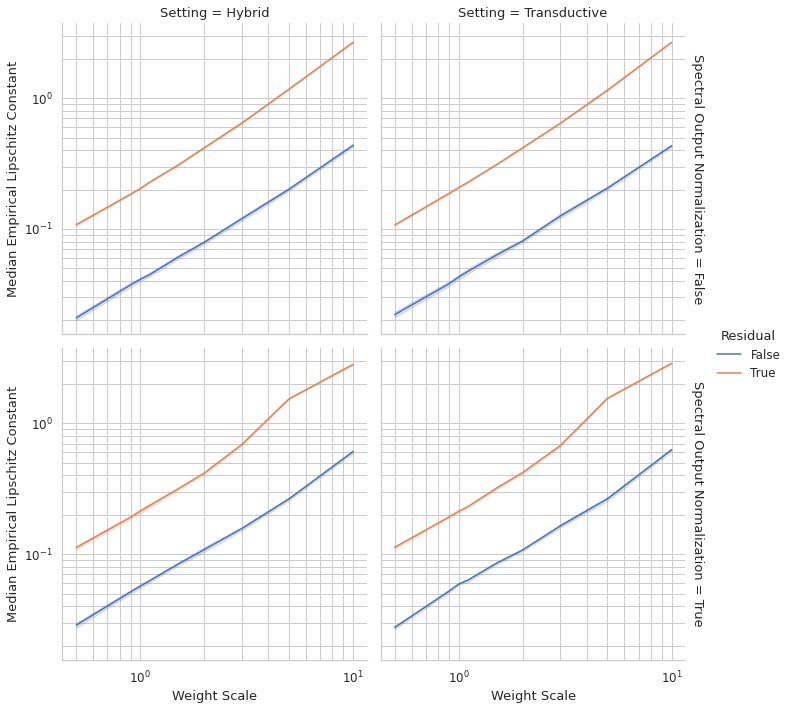

In [88]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = WEIGHT_SCALE, y = LIPSCHITZ, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, ci=_confidence_interval)
g.set(xscale='log', yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
    ax.yaxis.grid(True, which='minor')

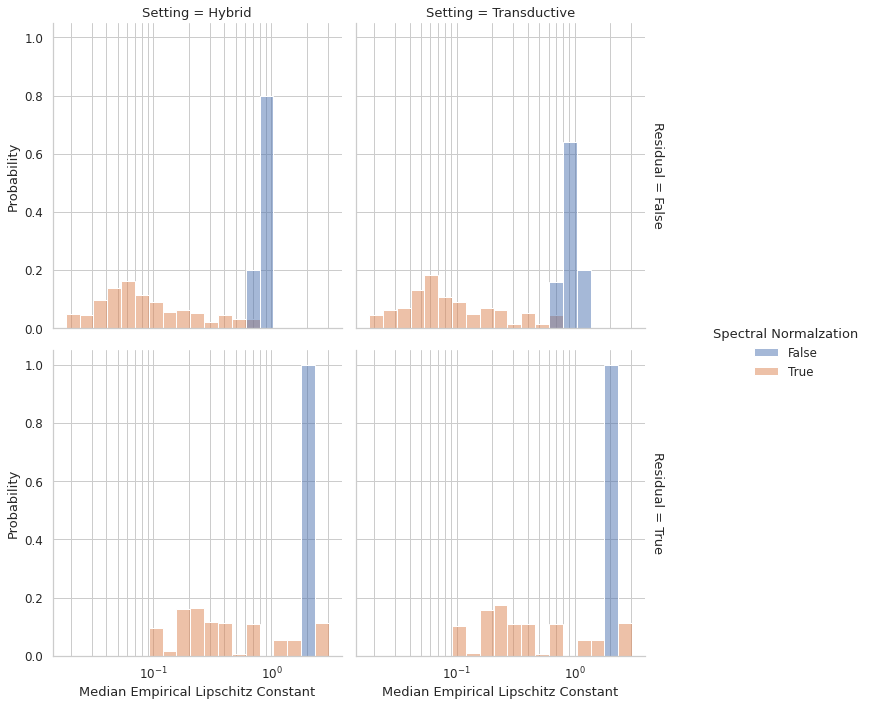

In [78]:


sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df, x=LIPSCHITZ, hue = SPECTRAL_NORM, col = SETTING, row=RESIDUAL,
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability', log_scale=True, common_norm=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

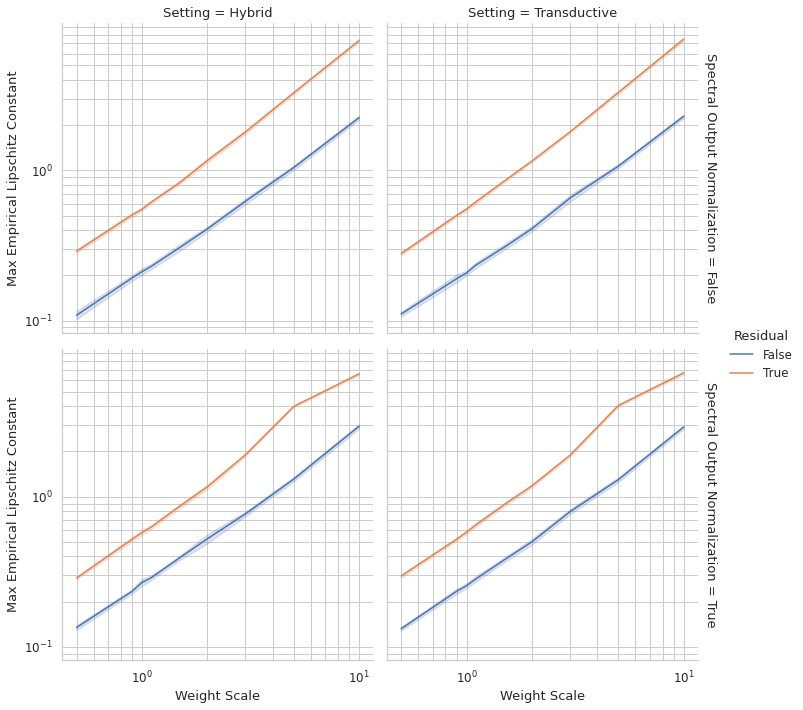

In [96]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = WEIGHT_SCALE, y = LIPSCHITZ_MAX, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='line', facet_kws = {'margin_titles' : True}, ci=_confidence_interval)
g.set(xscale='log', yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
    ax.yaxis.grid(True, which='minor')

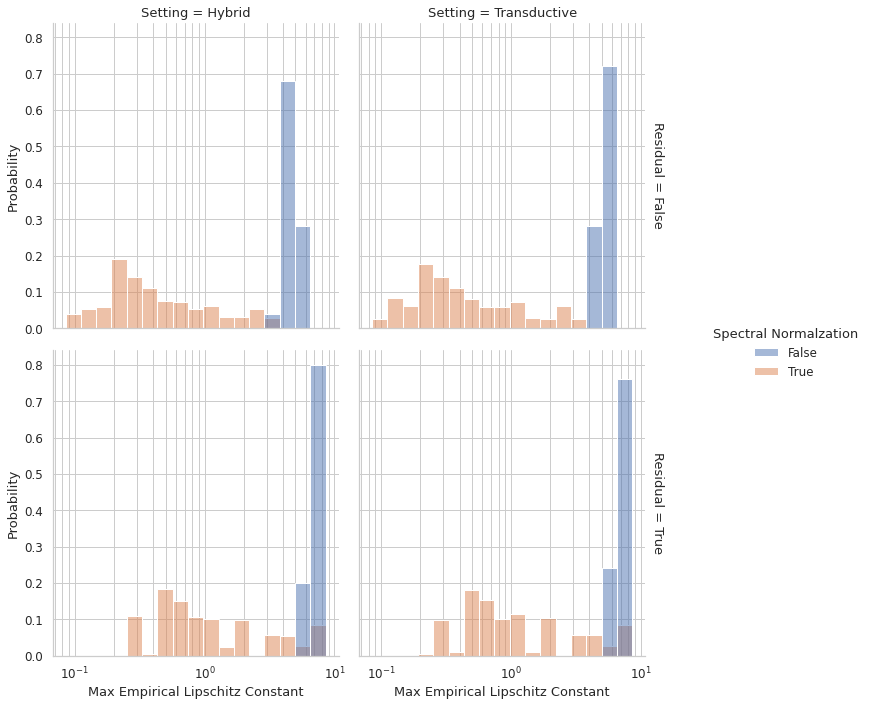

In [98]:


sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.displot(data = df, x=LIPSCHITZ_MAX, hue = SPECTRAL_NORM, col = SETTING, row=RESIDUAL,
                kind='hist', facet_kws = {'margin_titles' : True}, stat='probability', log_scale=True, common_norm=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

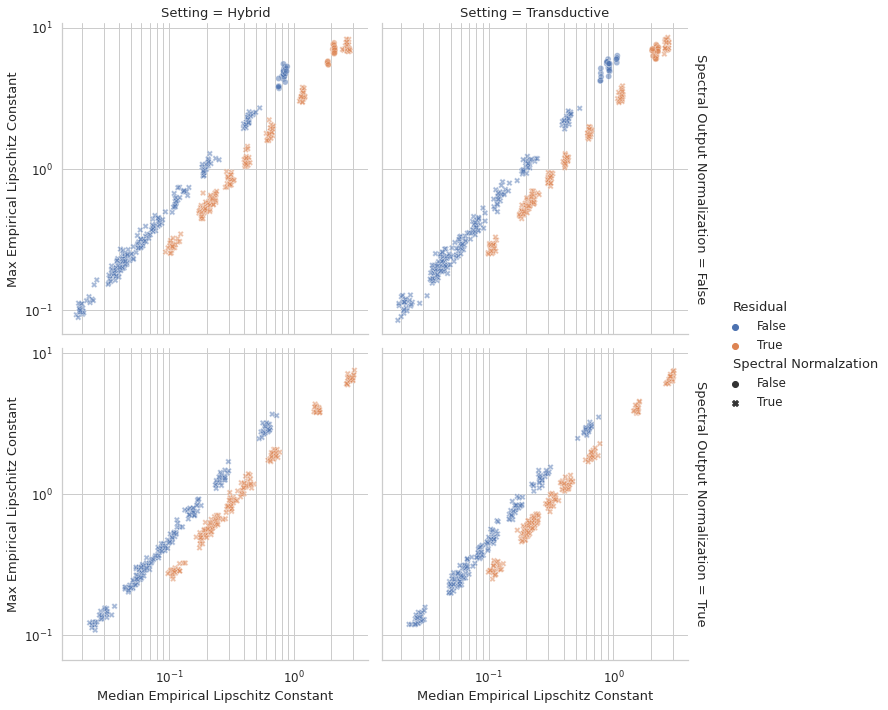

In [101]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ, y = LIPSCHITZ_MAX, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log', yscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

## Correlation of Accuarcy and Calibration with Lipschitz Constant

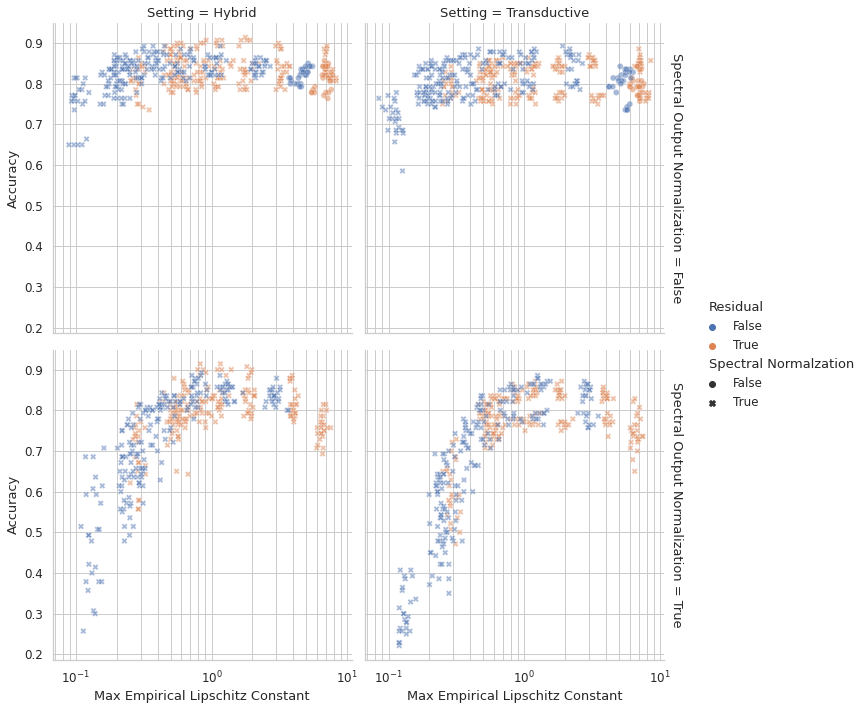

In [97]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ, y = ACCURACY, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

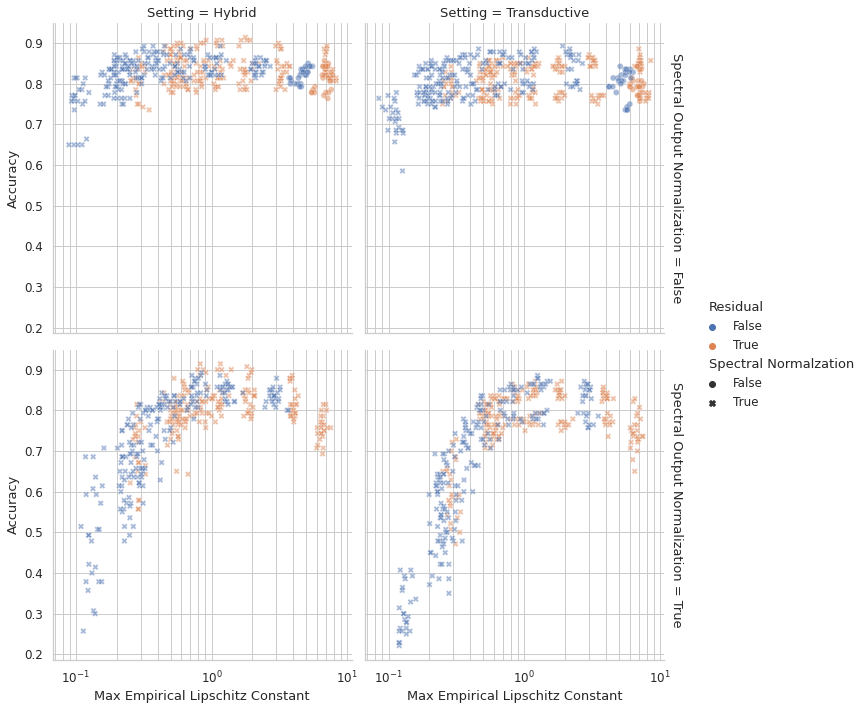

In [102]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ_MAX, y = ACCURACY, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

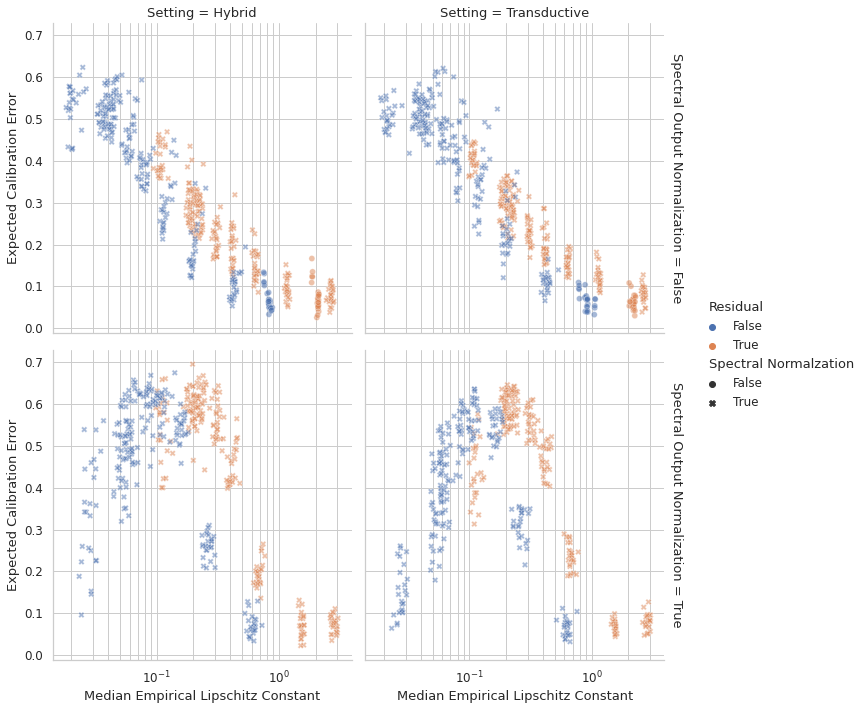

In [86]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ, y = ECE, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

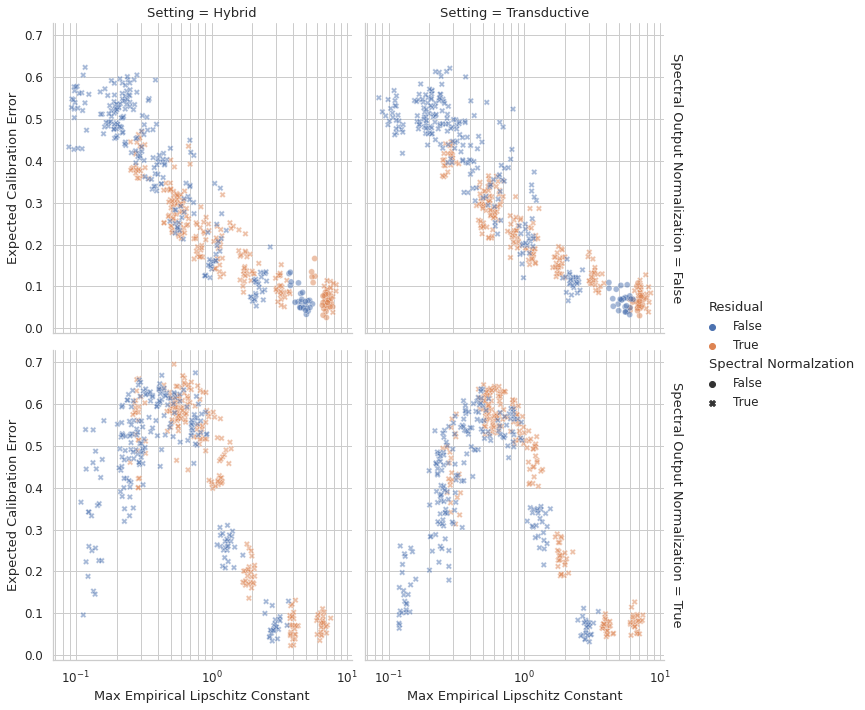

In [103]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df, x = LIPSCHITZ_MAX, y = ECE, hue = RESIDUAL, col = SETTING, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

## Effect of Lipschitz Constant on OOD-Detection

### Feature Density

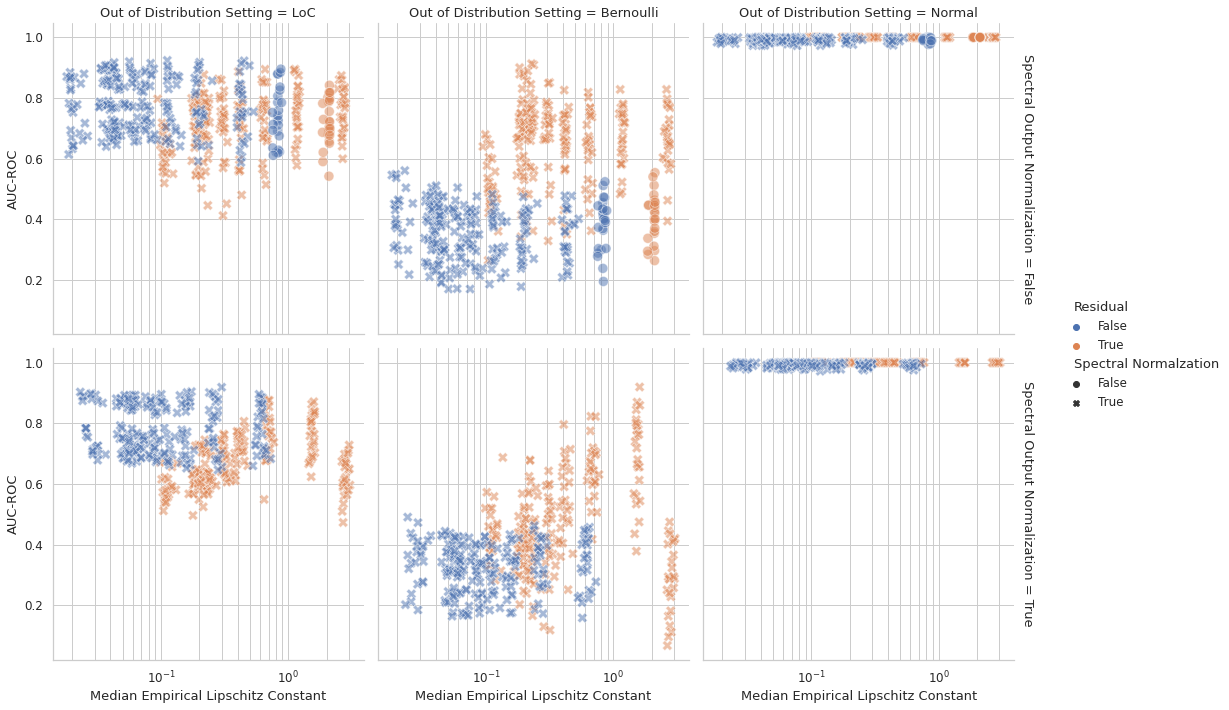

In [87]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df_auroc[
    (df_auroc[SETTING] == HYBRID) & (df_auroc[PROXY] == GPC)
] , x = LIPSCHITZ, y = AUROC, hue = RESIDUAL, col = OOD, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, s=100,alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

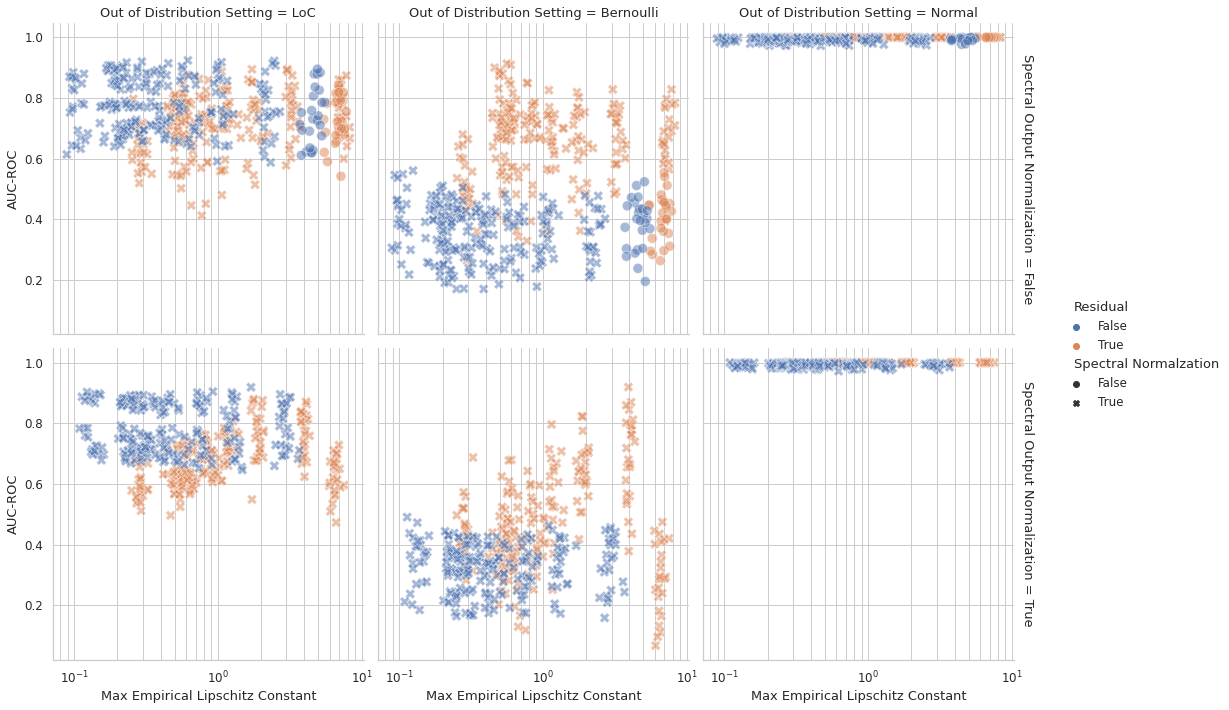

In [104]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df_auroc[
    (df_auroc[SETTING] == HYBRID) & (df_auroc[PROXY] == GPC)
] , x = LIPSCHITZ_MAX, y = AUROC, hue = RESIDUAL, col = OOD, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, s=100,alpha=0.5, style=SPECTRAL_NORM)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

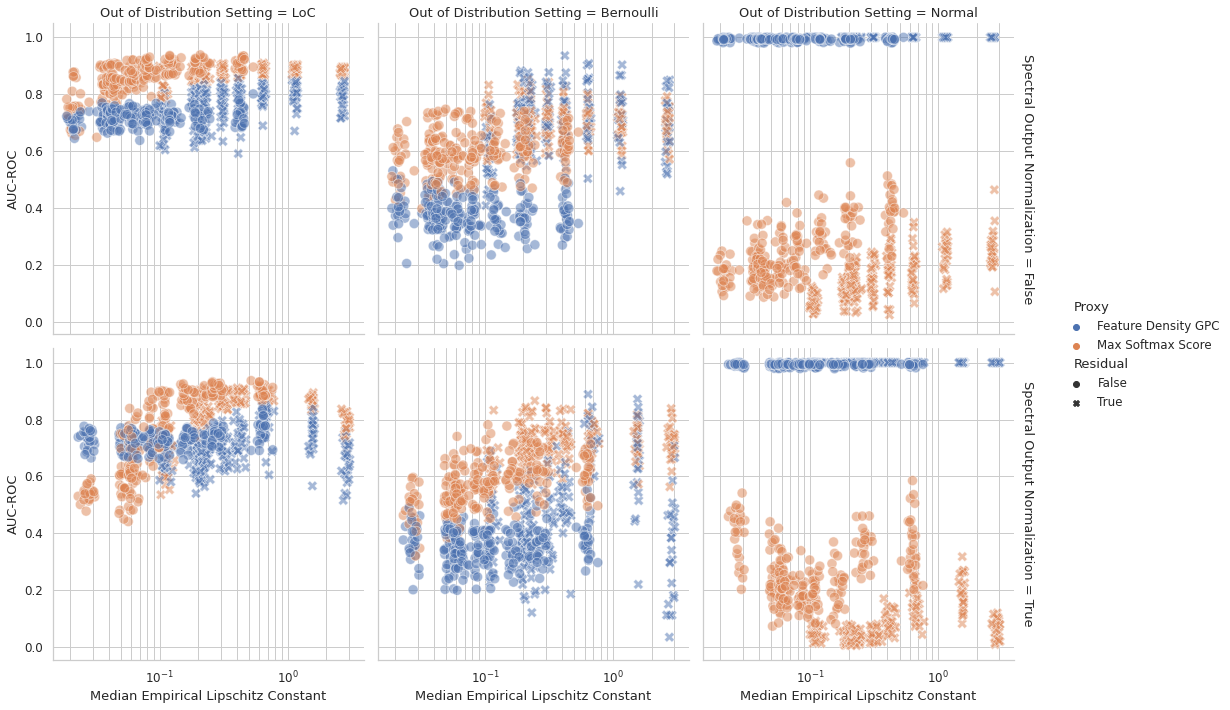

In [71]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df_auroc[df_auroc[SETTING] == TRANSDUCTIVE] , x = LIPSCHITZ, y = AUROC, hue = PROXY, col = OOD, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, style=RESIDUAL, s=100,alpha=0.5)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

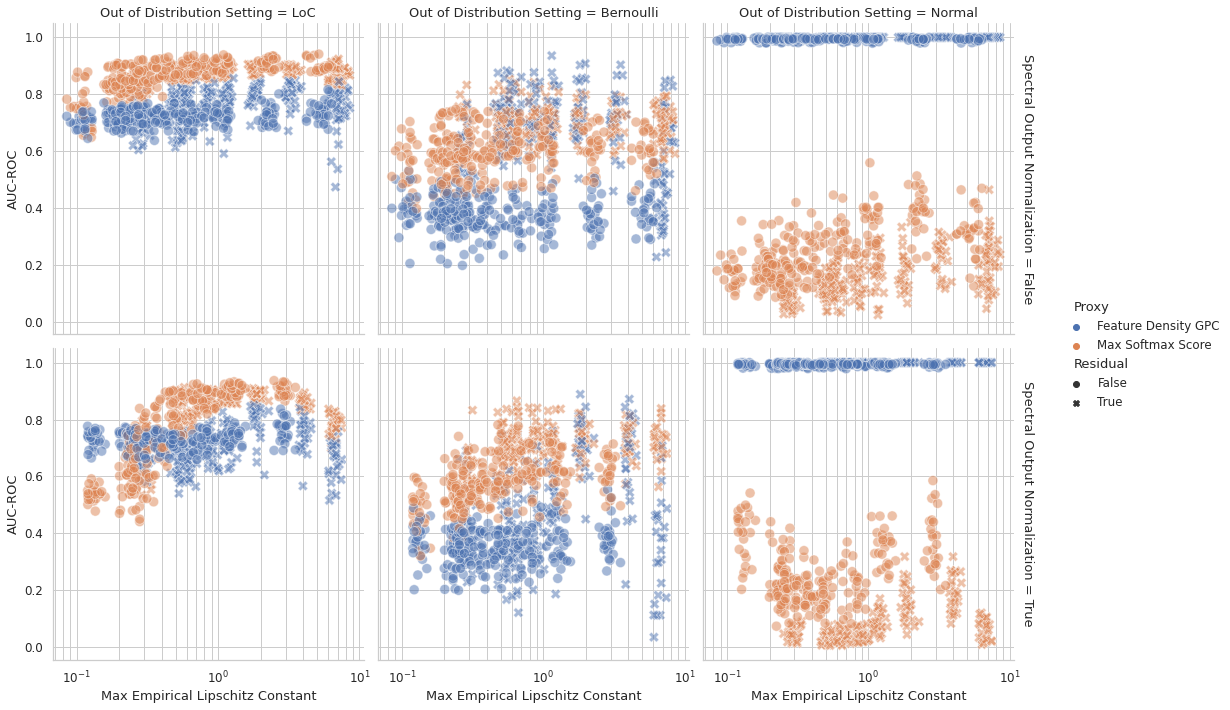

In [105]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df_auroc[df_auroc[SETTING] == TRANSDUCTIVE] , x = LIPSCHITZ_MAX, y = AUROC, hue = PROXY, col = OOD, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, style=RESIDUAL, s=100,alpha=0.5)
g.set(xscale='log')
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')

### Importance of accuracy for AUC-ROC LoC

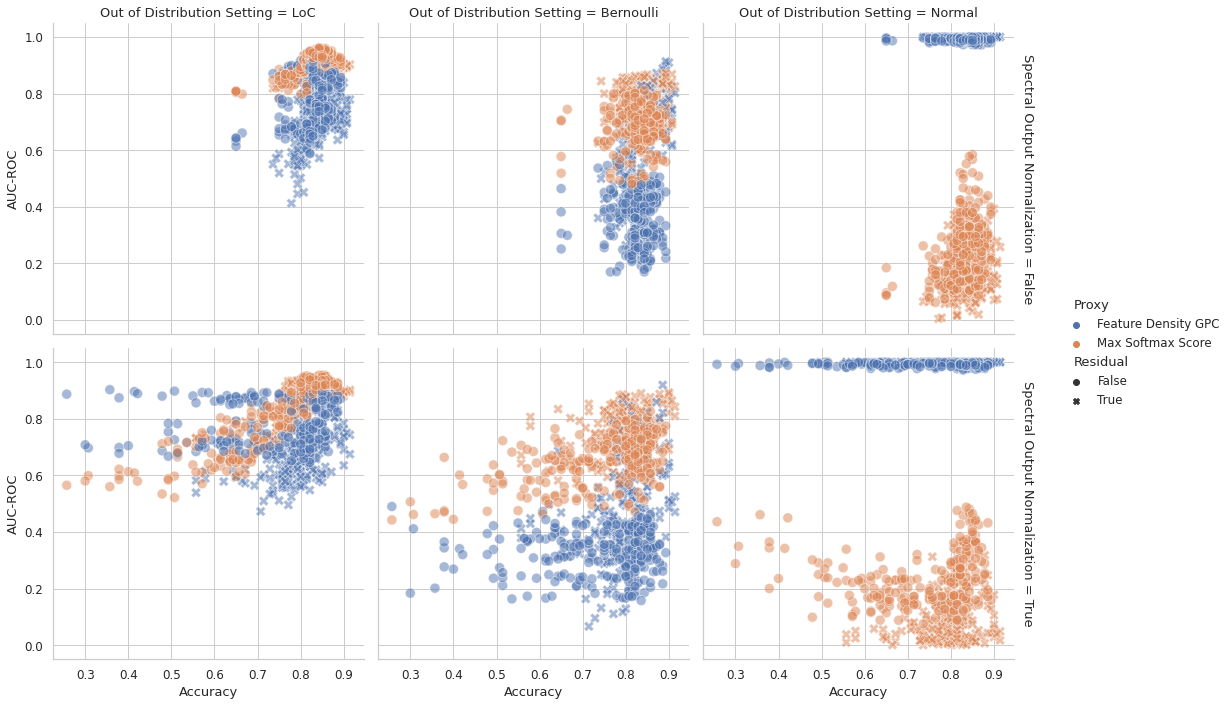

In [76]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")
g = sns.relplot(data = df_merged[df_merged[SETTING] == HYBRID] , x = ACCURACY, y = AUROC, hue = PROXY, col = OOD, 
                row = NORMALIZE_OUTPUT, kind='scatter', facet_kws = {'margin_titles' : True}, style=RESIDUAL, s=100,alpha=0.5)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')